<a href="https://colab.research.google.com/github/sayevvv/PCVK_2025/blob/main/PCVK_modul6_Abdullah_Shamil_Basayev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODUL 6 – Histogram, Histogram Equalization, Dithering

In [6]:
# Mount Google Drive dan siapkan path gambar "kitten"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob

# Path yang kamu minta (tanpa slash depan), dan fallback dengan slash
USER_PATH = "content/drive/MyDrive/image/kitten"
CANDIDATES = [
    USER_PATH,
    "/" + USER_PATH.lstrip("/"),
    "/content/drive/MyDrive/PCVK/Images/kitten",
]

# Jika user tidak menuliskan ekstensi, coba beberapa ekstensi umum
EXTS = ["", ".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"]

def resolve_image_path():
    # 1) coba exact match kandidat + ekstensi
    for base in CANDIDATES:
        for ext in EXTS:
            p = base if base.lower().endswith(tuple([e for e in EXTS if e])) else base + ext
            if os.path.exists(p):
                return p
    # 2) kalau base adalah folder, cari file pertama di dalamnya
    for base in CANDIDATES:
        if os.path.isdir(base):
            files = []
            for ext in EXTS[1:]:
                files.extend(glob.glob(os.path.join(base, f"*{ext}")))
            if files:
                return files[0]
    raise FileNotFoundError("Gambar 'kitten' tidak ditemukan. Periksa path/ekstensi.")

IMG_PATH = resolve_image_path()
IMG_PATH


Mounted at /content/drive


'/content/drive/MyDrive/PCVK/Images/kitten.jpg'

#Cell 1 — Import Library & Helper

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def imread_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Cannot read image at: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def to_gray(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def show_side_by_side(imgs, titles=None, cmap=None, figsize=(14,5)):
    plt.figure(figsize=figsize)
    n = len(imgs)
    for i,(im) in enumerate(imgs, 1):
        plt.subplot(1,n,i)
        if im.ndim == 2:
            plt.imshow(im, cmap=cmap or 'gray')
        else:
            plt.imshow(im)
        if titles:
            plt.title(titles[i-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


#Cell 2 — Tampilkan Gambar Asli (RGB & Grayscale)

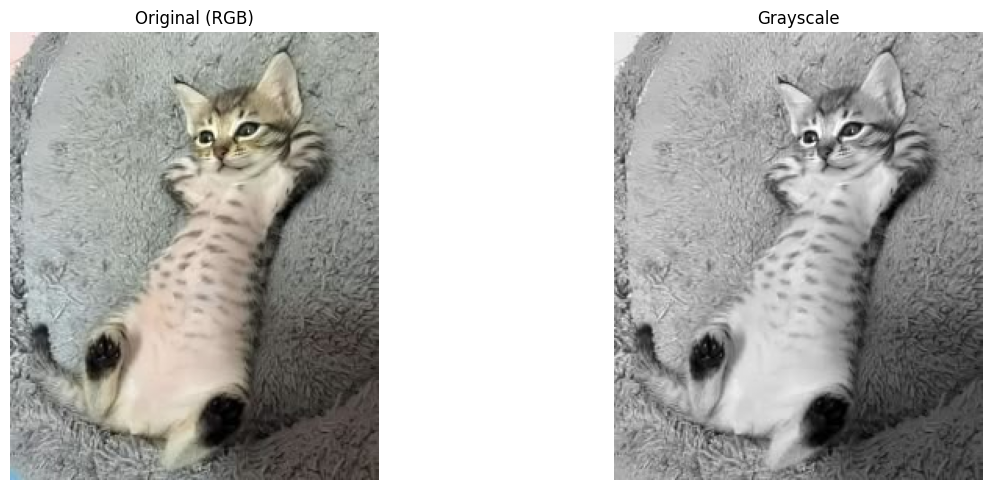

In [7]:
rgb = imread_rgb(IMG_PATH)
gray = to_gray(rgb)
show_side_by_side([rgb, gray], ["Original (RGB)", "Grayscale"])


#(3) Histogram Citra — Implementasi Manual (sesuai flowchart modul)
Cell 3 — Hitung Histogram Grayscale (Manual, loop pixel)

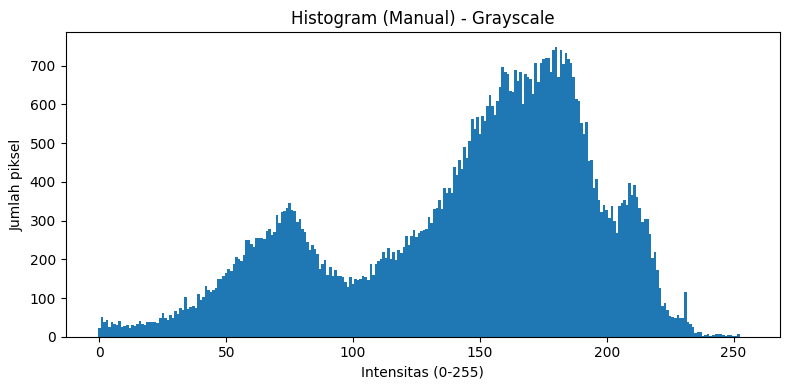

In [8]:
# Inisialisasi array histogram 256 level untuk grayscale
hist_manual = np.zeros(256, dtype=np.int64)

h, w = gray.shape
for y in range(h):
    for x in range(w):
        hist_manual[ gray[y, x] ] += 1

# Visualisasi histogram manual
plt.figure(figsize=(8,4))
plt.bar(np.arange(256), hist_manual, width=1.0)
plt.title("Histogram (Manual) - Grayscale")
plt.xlabel("Intensitas (0-255)")
plt.ylabel("Jumlah piksel")
plt.tight_layout()
plt.show()


#(4) Histogram Citra — NumPy histogram & Bandingkan
Cell 4 — Histogram dengan NumPy vs Manual

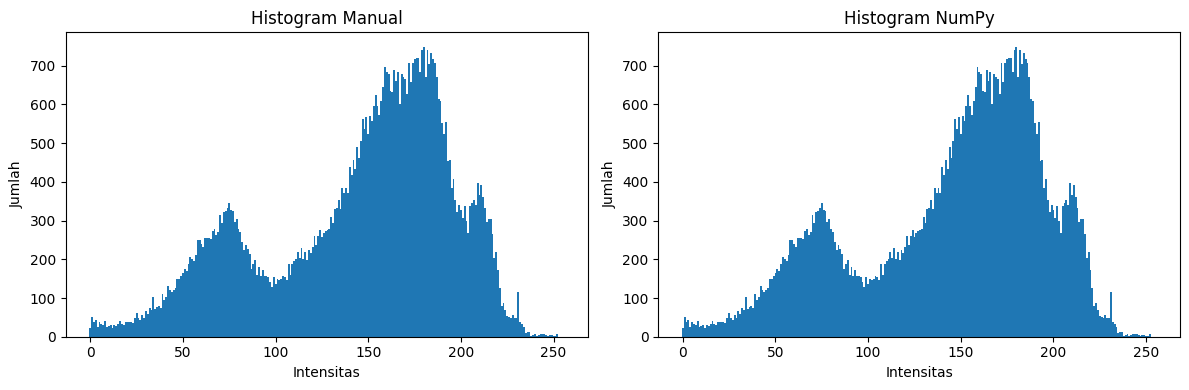

Apakah sama persis? True


In [9]:
hist_np, bins = np.histogram(gray.ravel(), bins=256, range=(0,256))

# Plot perbandingan
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(np.arange(256), hist_manual, width=1.0)
plt.title("Histogram Manual")
plt.xlabel("Intensitas"); plt.ylabel("Jumlah")

plt.subplot(1,2,2)
plt.bar(np.arange(256), hist_np, width=1.0)
plt.title("Histogram NumPy")
plt.xlabel("Intensitas"); plt.ylabel("Jumlah")

plt.tight_layout()
plt.show()

# (Opsional) cek kesamaan nilai
print("Apakah sama persis?", np.array_equal(hist_manual, hist_np))


#(5) Histogram Equalization — Implementasi Manual (pakai gambar grayscale)
Cell 5 — HE Manual: CDF → Mapping → Apply

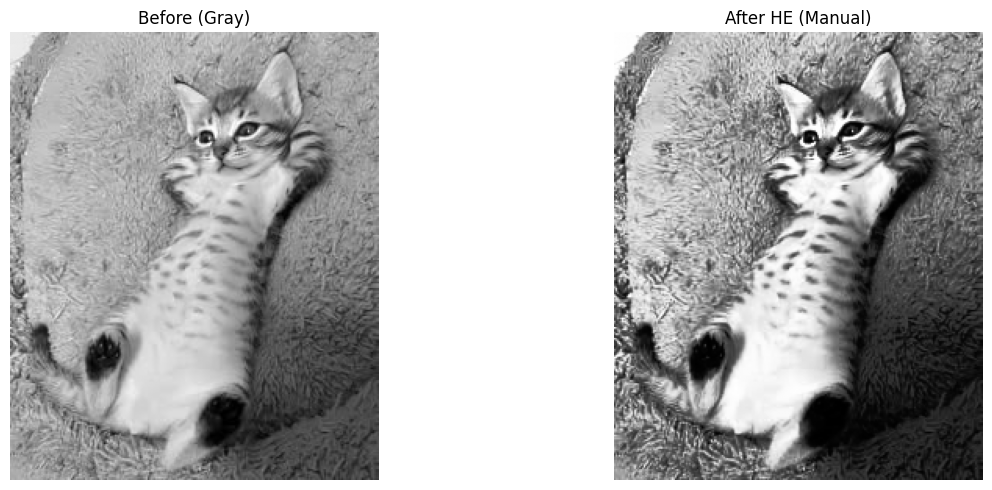

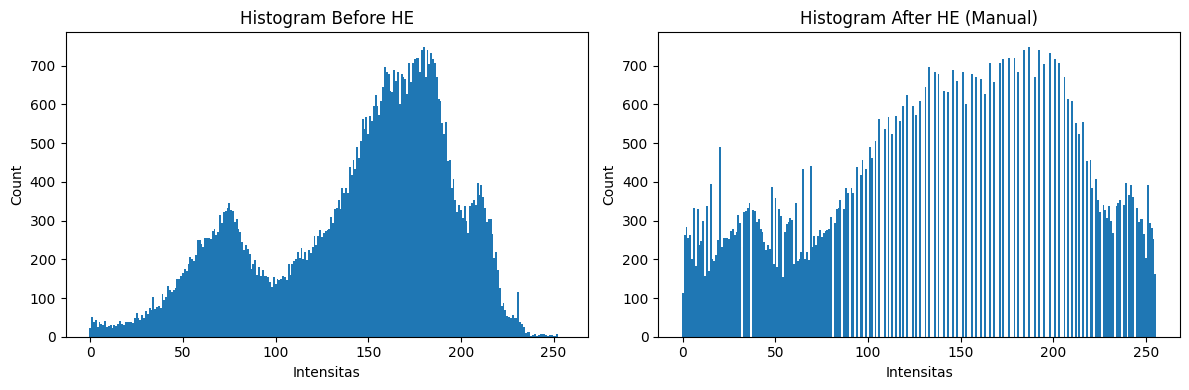

In [10]:
# Hitung hist, PDF, CDF
hist = hist_manual.astype(np.float64)
pdf = hist / hist.sum()
cdf = np.cumsum(pdf)

# Transform function s = (L-1) * CDF
L = 256
mapping = np.floor((L-1) * cdf + 0.5).astype(np.uint8)

# Terapkan mapping ke seluruh piksel
he_manual = mapping[gray]

# Tampilkan hasil & histogram
show_side_by_side([gray, he_manual], ["Before (Gray)", "After HE (Manual)"], cmap='gray')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(np.arange(256), hist, width=1.0)
plt.title("Histogram Before HE")
plt.xlabel("Intensitas"); plt.ylabel("Count")

plt.subplot(1,2,2)
hist_he, _ = np.histogram(he_manual.ravel(), bins=256, range=(0,256))
plt.bar(np.arange(256), hist_he, width=1.0)
plt.title("Histogram After HE (Manual)")
plt.xlabel("Intensitas"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


#(6) Histogram Equalization — OpenCV equalizeHist & Bandingkan
Cell 6 — HE OpenCV vs Manual

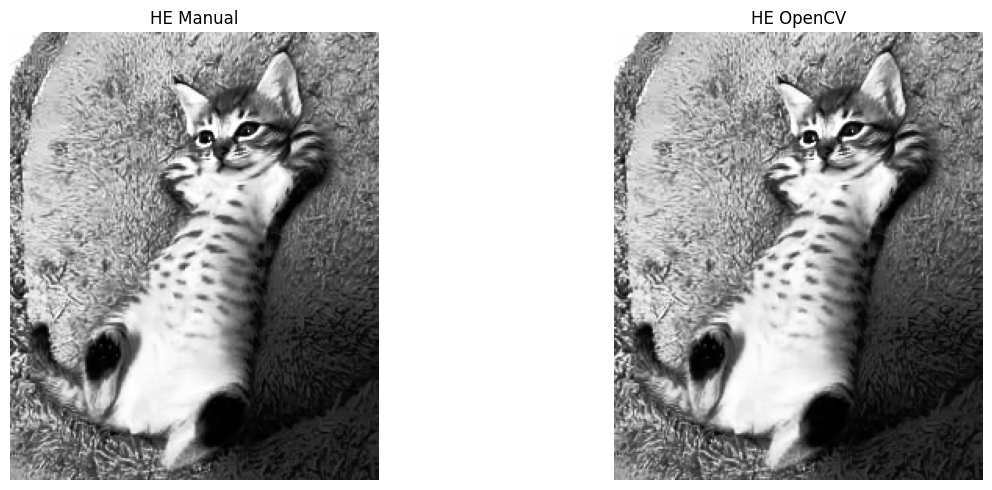

Sum of absolute differences: 2235


In [11]:
he_cv2 = cv2.equalizeHist(gray)

show_side_by_side([he_manual, he_cv2], ["HE Manual", "HE OpenCV"], cmap='gray')

# Cek perbedaan (biasanya sama/nyaris sama)
diff = cv2.absdiff(he_manual, he_cv2)
print("Sum of absolute differences:", diff.sum())


#(7) Kuantisasi 16 juta warna → 8 Warna Dasar (black, red, green, yellow, blue, magenta, cyan, white)
Cell 7 — 8-Color Quantization (Nearest Centroid in RGB)

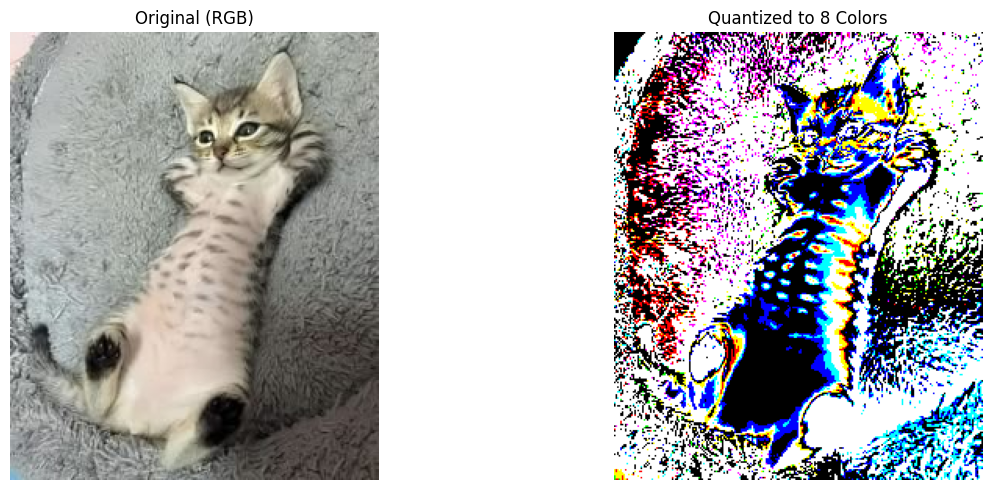

In [12]:
# Definisikan 8 warna dasar (RGB)
PALETTE = np.array([
    [  0,   0,   0],  # black
    [255,   0,   0],  # red
    [  0, 255,   0],  # green
    [255, 255,   0],  # yellow
    [  0,   0, 255],  # blue
    [255,   0, 255],  # magenta
    [  0, 255, 255],  # cyan
    [255, 255, 255],  # white
], dtype=np.uint8)

def quantize_to_palette(img_rgb, palette=PALETTE):
    h, w, _ = img_rgb.shape
    flat = img_rgb.reshape(-1, 3).astype(np.int16)
    # Hitung jarak Euclidean ke tiap warna palette
    # distance: (N_pixels, 8)
    dists = np.sum((flat[:, None, :] - palette[None, :, :])**2, axis=2)
    idx = np.argmin(dists, axis=1)
    flat_q = palette[idx]
    return flat_q.reshape(h, w, 3)

quant8 = quantize_to_palette(rgb, PALETTE)
show_side_by_side([rgb, quant8], ["Original (RGB)", "Quantized to 8 Colors"])


#(8) Dithering Floyd–Steinberg (Grayscale)
Cell 8 — Implementasi FS Dithering (biner 0/255)

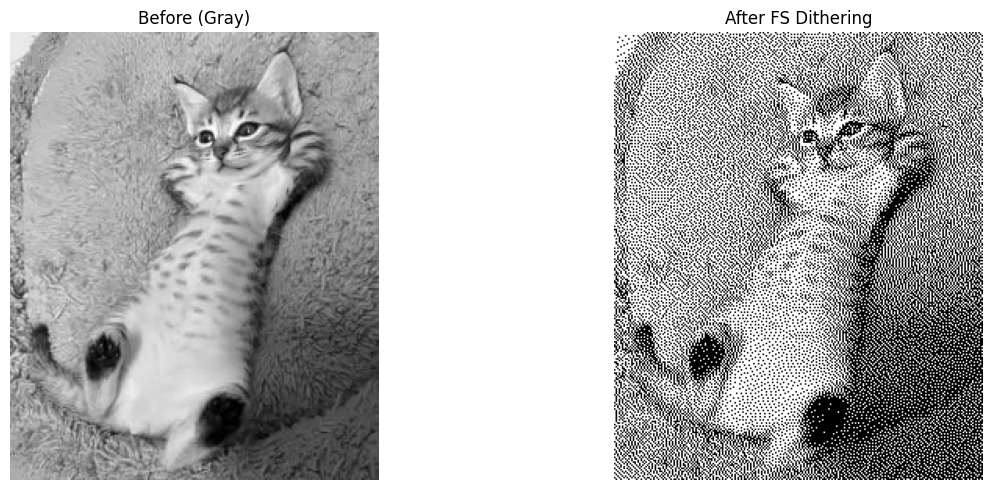

In [13]:
def floyd_steinberg_dither(gray_img):
    img = gray_img.astype(np.float32).copy()
    h, w = img.shape
    for y in range(h):
        for x in range(w):
            old = img[y, x]
            new = 0 if old < 128 else 255
            img[y, x] = new
            err = old - new
            # R1: (x+1, y)   += 7/16 * err
            if x+1 < w: img[y, x+1] += (7/16)*err
            # R2: (x-1, y+1) += 3/16 * err
            if y+1 < h and x-1 >= 0: img[y+1, x-1] += (3/16)*err
            # R3: (x, y+1)   += 5/16 * err
            if y+1 < h: img[y+1, x] += (5/16)*err
            # R4: (x+1, y+1) += 1/16 * err
            if y+1 < h and x+1 < w: img[y+1, x+1] += (1/16)*err
    # Clamp [0,255]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

dither_fs = floyd_steinberg_dither(gray)
show_side_by_side([gray, dither_fs], ["Before (Gray)", "After FS Dithering"], cmap='gray')


#(9) Pipeline: Gray → Histogram Equalization → FS Dithering
Cell 9 — HE lalu Dithering (Floyd–Steinberg)

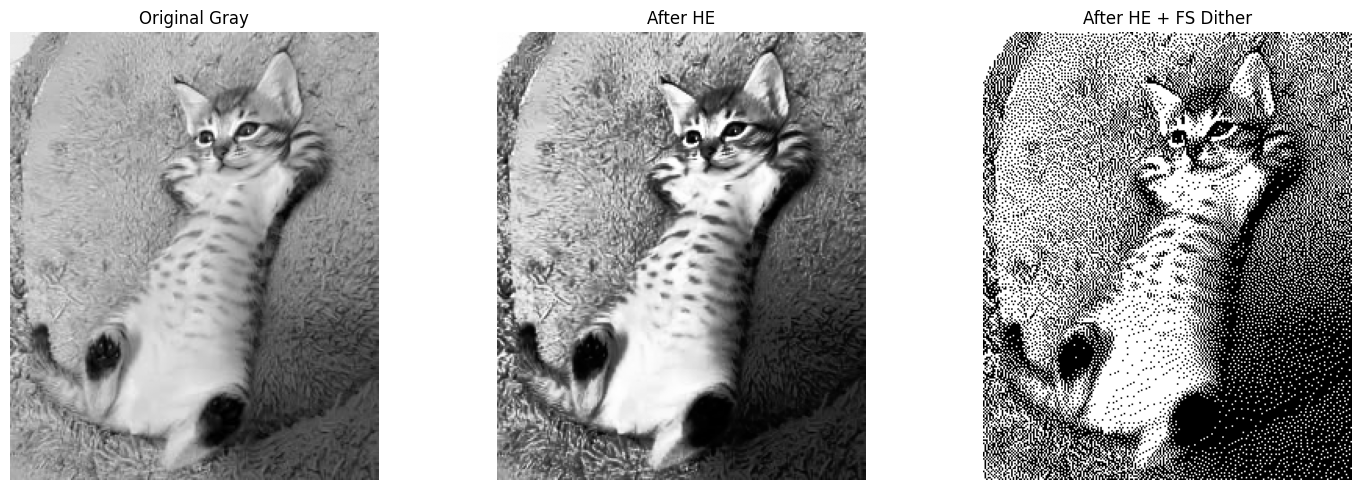

In [14]:
# Equalization pakai OpenCV atau manual; di sini pakai cv2 untuk ringkas
he_then = cv2.equalizeHist(gray)
dither_after_he = floyd_steinberg_dither(he_then)

show_side_by_side([gray, he_then, dither_after_he],
                  ["Original Gray", "After HE", "After HE + FS Dither"],
                  cmap='gray', figsize=(15,5))


# Kesimpulan

Praktikum ini memberikan pemahaman yang lebih dalam tentang bagaimana citra digital direpresentasikan dan diolah secara matematis untuk meningkatkan kualitas dan efisiensi visualnya.

Histogram Citra
Histogram menggambarkan distribusi intensitas piksel dalam citra. Melalui perhitungan manual dan fungsi np.histogram, diperoleh pemahaman bahwa histogram dapat menunjukkan tingkat kecerahan dan kontras citra. Semakin merata distribusi histogram, semakin baik penyebaran kecerahan dalam gambar.

Histogram Equalization (HE)
Proses ini meningkatkan kontras gambar dengan menggunakan Cumulative Distribution Function (CDF) untuk mendistribusikan ulang nilai intensitas piksel. Hasilnya, detail pada area gelap dan terang menjadi lebih terlihat. Perbandingan antara hasil manual dan cv2.equalizeHist() menunjukkan bahwa prinsip keduanya sama, hanya berbeda dalam efisiensi perhitungan.

Kuantisasi Warna (8 Warna Dasar)
Kuantisasi warna berfungsi untuk mengurangi jumlah warna dalam citra menjadi sejumlah warna tertentu. Dengan menggunakan delapan warna dasar, citra tetap bisa dikenali meskipun mengalami penyederhanaan. Proses ini berguna untuk kompresi data dan efisiensi penyimpanan, meski ada penurunan detail visual.

Dithering (Floyd–Steinberg)
Dithering memperbaiki hasil kuantisasi atau binerisasi dengan menyebarkan kesalahan intensitas ke piksel di sekitarnya. Metode Floyd–Steinberg membuat citra biner terlihat lebih halus, menyerupai gradasi abu-abu meskipun hanya terdiri dari dua warna (hitam dan putih).

Integrasi Proses
Kombinasi antara konversi grayscale, histogram equalization, dan dithering menunjukkan bagaimana tahapan pengolahan citra dapat saling melengkapi. Setiap langkah berperan dalam meningkatkan kualitas visual citra, baik dari sisi distribusi intensitas maupun persepsi visual.